In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# **Functions**

In [2]:
def binary_entropy(x):
  if x > 0 and x < 1:
    return -x*np.log2(x) - (1-x)*np.log2(1-x)
  elif x == 0 or x == 1:
    return 0
  elif x > 1 or x < 0:
    raise ValueError("x must be between 0 and 1")

def channel_matrix_rank(nt, nr):
  return np.min([nt, nr])

def theorem1_large_l(rank_H, nq):
  alpha = np.min([rank_H / nq, 0.5])
  return nq * binary_entropy(alpha)

def theorem1(rank_H, nq, l):
  return (1/l) * math.log2(sum(math.comb(l * nq, j) for j in range(l * rank_H + 1)))

def waterfilling(sigma2, P_tot):
    """
    Standard water-filling over parallel Gaussian subchannels of gains sigma2 (array).
      sum_k Pk = P_tot.
    Returns the power allocation Pk for each subchannel.
    """
    # We solve for μ in sum_k max(μ - 1/sigma2[k], 0) = P_tot by bisection
    def total_power(mu):
        return np.sum(np.maximum(mu - 1.0 / sigma2, 0.0))

    # Bracket the water‐level μ
    mu_low = 0
    mu_high = P_tot + np.max(1.0 / sigma2)
    for _ in range(60):
        mu_mid = 0.5 * (mu_low + mu_high)
        if total_power(mu_mid) > P_tot:
            mu_high = mu_mid
        else:
            mu_low = mu_mid
    mu = 0.5 * (mu_low + mu_high)
    Pk = np.maximum(mu - 1.0 / sigma2, 0.0)
    return Pk

def compute_discrete_mi(sigma, Pk, n_qk, num_noise=1000):
    """
    Monte Carlo estimate of I(X; Y) for one real subchannel:
      Y = sigma * X + N,   N ~ N(0,1),
      X ~ PAM(2^n_qk)-alphabet with power Pk (i.e. E[X^2]=Pk).
    Returns I(X; Y) in bits.  We do num_noise samples per constellation point.
    """
    if n_qk == 0 or Pk <= 1e-12:
        return 0.0

    M = 2**n_qk
    # Build M‐PAM constellation with spacing to yield E[X^2]=Pk
    a = np.sqrt(3 * Pk / (M**2 - 1))
    # Constellation points: { a * ( -M+1 , -M+3 , … , +M-3 , +M-1 ) }
    xs = a * (2*np.arange(1, M+1) - 1 - M)  # length‐M array

    # Monte Carlo: for each x_i, generate num_noise “Y = sigma * x_i + N” samples
    # then form the posterior p(x=j | y) to compute H(X|Y), and hence I=H(X) - H(X|Y).
    total_entropy = 0.0
    total_samples = 0

    for i in range(M):
        noise = np.random.randn(num_noise)
        y_samples = sigma * xs[i] + noise  # shape (num_noise,)

        # Compute p(y|x=j) for all j at each y.  shape: (num_noise, M)
        diffs = y_samples[:,None] - sigma*xs[None,:]
        exponents = -0.5*diffs**2

        # Numerically stabilize by subtracting row‐wise max
        rowmax = np.max(exponents, axis=1, keepdims=True)
        exps = np.exp(exponents - rowmax)
        ps = exps / np.sum(exps, axis=1, keepdims=True)  # shape (num_noise, M)

        # Conditional entropy per sample: -sum_j p_i_j log2 p_i_j
        h_cond_samples = -np.sum(ps * np.log2(ps + 1e-12), axis=1)
        total_entropy += np.sum(h_cond_samples)
        total_samples += num_noise

    H_X = np.log2(M)
    H_X_given_Y = total_entropy / total_samples
    return H_X - H_X_given_Y

# **Fig. 10 Implementation**

<ipython-input-63-9ec049be0a74>:13: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.min([rank_H / nq, 0.5])


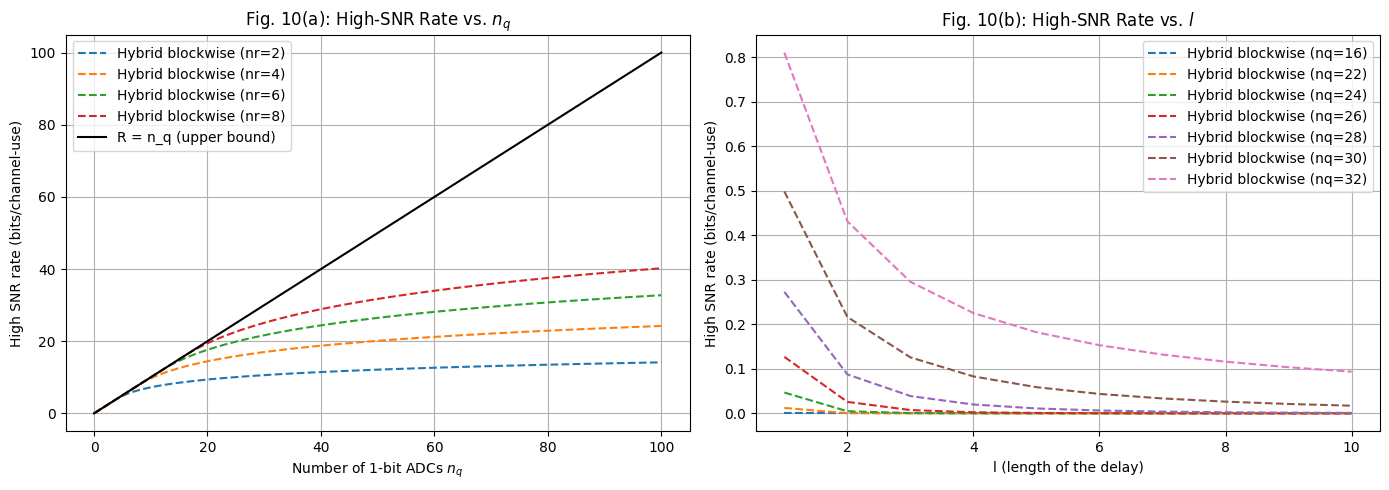

In [ ]:
nqs_a = np.arange(0, 101)   # number of one-bit ADCs
nrs_a = [2, 4, 6, 8]        # receive antenna counts
nt_a = 10                   # number of transmit antennas
# Prepare the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
ax = axs[0]
# Plot dotted lines for hybrid blockwise receiver (large delay)
for nr in nrs_a:
  # Asymptotic high-SNR rate
  rank_H = channel_matrix_rank(nt_a, nr)
  ch = [theorem1_large_l(rank_H, nq) for nq in nqs_a]
  ax.plot(nqs_a, ch, linestyle='--', label=f'Hybrid blockwise (nr={nr})')

# Plot solid upper bound R = n_q
ax.plot(nqs_a, nqs_a, 'k-', label='R = n_q (upper bound)')

# Labels and legend
ax.set_xlabel('Number of 1-bit ADCs $n_q$')
ax.set_ylabel('High SNR rate (bits/channel-use)')
ax.set_title('Fig. 10(a): High-SNR Rate vs. $n_q$')
ax.legend()
ax.grid(True)

nqs_b = [16, 22, 24, 26, 28, 30, 32]
rank_H_b = 16
l = np.arange(1, 11)

ax = axs[1]

# Plot dotted lines for hybrid blockwise receiver (large delay)
loss = {nq: [] for nq in nqs_b}
for nq in nqs_b:
  for L in l:
    # Asymptotic high-SNR rate for large l
    C_inf = theorem1_large_l(rank_H_b, nq)
    # Asymptotic high-SNR rate
    C_l = theorem1(rank_H_b, nq, L)
    loss[nq].append(C_inf - C_l)

  ax.plot(l, loss[nq], linestyle='--', label=f'Hybrid blockwise (nq={nq})')

# Labels and legend
ax.set_xlabel('l (length of the delay)')
ax.set_ylabel('High SNR rate (bits/channel-use)')
ax.set_title('Fig. 10(b): High-SNR Rate vs. $l$')
ax.legend()
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# **Fig. 11 Implementation**

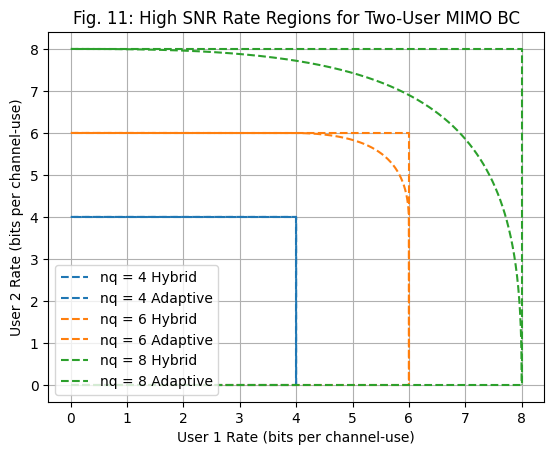

In [ ]:
nqs = [4, 6, 8]
nt, nr = 10, 4
rank_H = channel_matrix_rank(nt, nr)
etas = np.linspace(0, 1, 500)
plt.figure()
for nq in nqs:
  R1_hyb = []
  R2_hyb = []
  for eta in etas:
    R1_hyb.append(theorem1_large_l(eta * rank_H, nq))
    R2_hyb.append(theorem1_large_l((1 - eta) * rank_H, nq))
  line_hyb, = plt.plot(R1_hyb, R2_hyb, linestyle='--', label=f'nq = {nq} Hybrid')
  color = line_hyb.get_color()
  R1_adp = [0, nq, nq, 0]
  R2_adp = [0, 0, nq, nq]
  plt.plot(R1_adp, R2_adp, color=color, linestyle='--', label=f'nq = {nq} Adaptive')
plt.xlabel('User 1 Rate (bits per channel-use)')
plt.ylabel('User 2 Rate (bits per channel-use)')
plt.title('Fig. 11: High SNR Rate Regions for Two-User MIMO BC')
plt.grid(True)
plt.legend()
plt.show()

# **Fig. 12 Implementation**

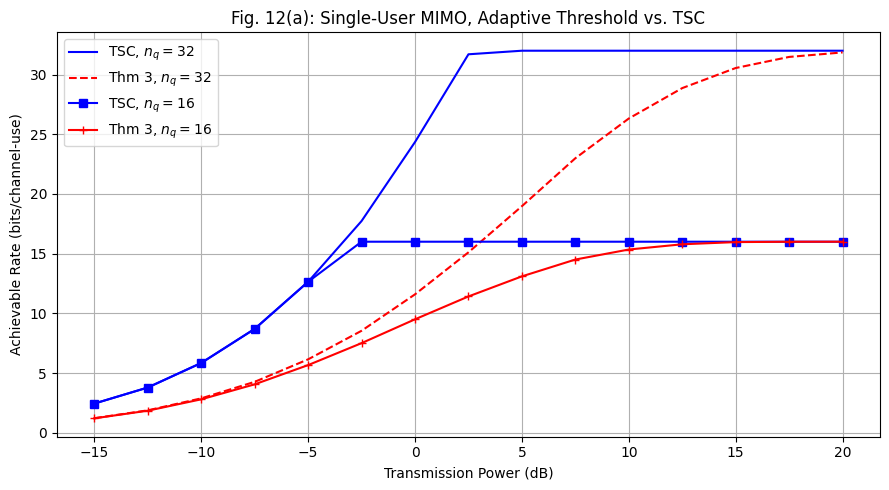

In [3]:
# Part (a): Single‐User MIMO
np.random.seed(0)
nt = 16
nr = 32
s = min(nt, nr)            # rank(H) (we assume ~full rank on average)
num_chan = 100             # # of channel realizations
num_noise_samples = 1000   # MC samples per constellation point
snr_db = np.linspace(-15, 20, 15)

avg_rate_thm3_32 = np.zeros_like(snr_db)
avg_rate_thm3_16 = np.zeros_like(snr_db)
avg_tsc_32      = np.zeros_like(snr_db)
avg_tsc_16      = np.zeros_like(snr_db)

for idx, snr in enumerate(snr_db):
    P_total = 10**(snr/10)
    sum_thm3_32   = 0.0
    sum_thm3_16   = 0.0
    sum_tsc32     = 0.0
    sum_tsc16     = 0.0

    for _ in range(num_chan):
        # Generate a random real‐Gaussian MIMO channel (nr x nt)
        H = np.random.randn(nr, nt)
        U, svals, Vt = np.linalg.svd(H, full_matrices=False)
        sigma2 = svals**2

        # 1) Shannon capacity + waterfilling
        Pk_shannon = waterfilling(sigma2, P_total)
        C_shannon = np.sum(np.log2(1 + sigma2 * Pk_shannon))

        # Truncated Shannon capacity:
        sum_tsc32 += min(32, C_shannon)
        sum_tsc16 += min(16, C_shannon)

        # Theorem 3 (adaptive threshold, discrete PAM) for n_q=32:
        #   n_q,k = 2 bits per subchannel, for k=1..16
        rate32 = 0.0
        for k in range(s):
            rate32 += compute_discrete_mi(svals[k], Pk_shannon[k], 2,
                                          num_noise=num_noise_samples)
        sum_thm3_32 += rate32

        # Theorem 3 for n_q=16:
        #   n_q,k = 1 bit per subchannel, for k=1..16
        rate16 = 0.0
        for k in range(s):
            rate16 += compute_discrete_mi(svals[k], Pk_shannon[k], 1,
                                          num_noise=num_noise_samples)
        sum_thm3_16 += rate16

    # Average across all channel draws
    avg_rate_thm3_32[idx] = sum_thm3_32 / num_chan
    avg_rate_thm3_16[idx] = sum_thm3_16 / num_chan
    avg_tsc_32[idx]     = sum_tsc32   / num_chan
    avg_tsc_16[idx]     = sum_tsc16   / num_chan

# Plot Fig. 12(a)
plt.figure(figsize=(9,5))
plt.plot(snr_db, avg_tsc_32, 'b-', label='TSC, $n_q=32$')
plt.plot(snr_db, avg_rate_thm3_32, 'r--', label='Thm 3, $n_q=32$')
plt.plot(snr_db, avg_tsc_16, 'b-s', label='TSC, $n_q=16$')
plt.plot(snr_db, avg_rate_thm3_16, 'r-+', label='Thm 3, $n_q=16$')

plt.xlabel('Transmission Power (dB)')
plt.ylabel('Achievable Rate (bits/channel-use)')
plt.title('Fig. 12(a): Single‐User MIMO, Adaptive Threshold vs. TSC')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

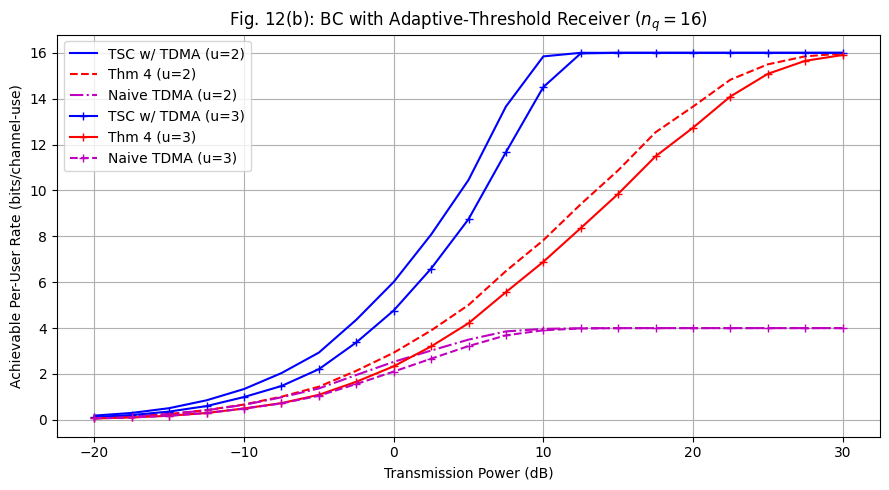

In [4]:
# Part (b): Multi‐User BC (Theorem 4)
np.random.seed(0)
nt = 16
nr_user = 4
snr_db = np.linspace(-20, 30, 21)

# We will do a smaller Monte Carlo here to keep things brisk
num_chan = 20
num_noise_samples = 200

# Allocate containers
avg_thm4_u2   = np.zeros_like(snr_db)
avg_naive_u2  = np.zeros_like(snr_db)
avg_tsc_u2    = np.zeros_like(snr_db)

avg_thm4_u3   = np.zeros_like(snr_db)
avg_naive_u3  = np.zeros_like(snr_db)
avg_tsc_u3    = np.zeros_like(snr_db)

for idx, snr in enumerate(snr_db):
    P_tot = 10**(snr/10)
    sum_t4_2   = 0.0
    sum_nv_2   = 0.0
    sum_tsc2   = 0.0
    sum_t4_3   = 0.0
    sum_nv_3   = 0.0
    sum_tsc3   = 0.0

    for _ in range(num_chan):
        # --------- 2‐User BC ---------
        H1 = np.random.randn(nr_user, nt)
        H2 = np.random.randn(nr_user, nt)
        U1, s1, _ = np.linalg.svd(H1, full_matrices=False)
        U2, s2, _ = np.linalg.svd(H2, full_matrices=False)
        sig21, sig22 = s1**2, s2**2

        # Each user gets 1/2 of time, so in its slot it has power P_tot/2
        Pk1_2 = waterfilling(sig21, P_tot * 0.5)
        Pk2_2 = waterfilling(sig22, P_tot * 0.5)

        # (a) Theorem 4: splitting n_q=16 equally among s=4 streams => 4 bits/stream
        rate1_t4 = sum(compute_discrete_mi(s1[k], Pk1_2[k], 4, num_noise=num_noise_samples)
                      for k in range(4))
        rate2_t4 = sum(compute_discrete_mi(s2[k], Pk2_2[k], 4, num_noise=num_noise_samples)
                      for k in range(4))
        # Each user only transmits 1/2 of the time => multiply by 1/2
        sum_t4_2 += 0.5 * (rate1_t4 + rate2_t4)

        # (b) “Naive TDMA”: each user again 1/2 time, uses Thm 3 with n_q=16 → 1 bit/stream
        rate1_nv = sum(compute_discrete_mi(s1[k], Pk1_2[k], 1, num_noise=num_noise_samples)
                      for k in range(4))
        rate2_nv = sum(compute_discrete_mi(s2[k], Pk2_2[k], 1, num_noise=num_noise_samples)
                      for k in range(4))
        sum_nv_2 += 0.5 * (rate1_nv + rate2_nv)

        # (c) Truncated‐Shannon TDMA:
        cap1 = np.sum(np.log2(1 + sig21 * Pk1_2))
        cap2 = np.sum(np.log2(1 + sig22 * Pk2_2))
        sum_tsc2 += 0.5 * (min(16, cap1) + min(16, cap2))


        # --------- 3‐User BC ---------
        H3 = np.random.randn(nr_user, nt)
        U3, s3, _ = np.linalg.svd(H3, full_matrices=False)
        sig23 = s3**2

        # Each user gets 1/3 of time → power P_tot/3
        Pk1_3 = waterfilling(sig21, P_tot/3)
        Pk2_3 = waterfilling(sig22, P_tot/3)
        Pk3_3 = waterfilling(sig23, P_tot/3)

        # (a) Theorem 4: allocate 16→4 bits/stream for s=4
        rate1_t4_3 = sum(compute_discrete_mi(s1[k], Pk1_3[k], 4, num_noise=num_noise_samples) for k in range(4))
        rate2_t4_3 = sum(compute_discrete_mi(s2[k], Pk2_3[k], 4, num_noise=num_noise_samples) for k in range(4))
        rate3_t4_3 = sum(compute_discrete_mi(s3[k], Pk3_3[k], 4, num_noise=num_noise_samples) for k in range(4))
        sum_t4_3 += (1/3)*(rate1_t4_3 + rate2_t4_3 + rate3_t4_3)

        # (b) Naive TDMA:
        rate1_nv_3 = sum(compute_discrete_mi(s1[k], Pk1_3[k], 1, num_noise=num_noise_samples) for k in range(4))
        rate2_nv_3 = sum(compute_discrete_mi(s2[k], Pk2_3[k], 1, num_noise=num_noise_samples) for k in range(4))
        rate3_nv_3 = sum(compute_discrete_mi(s3[k], Pk3_3[k], 1, num_noise=num_noise_samples) for k in range(4))
        sum_nv_3 += (1/3)*(rate1_nv_3 + rate2_nv_3 + rate3_nv_3)

        # (c) Truncated‐Shannon (per user, TDMA):
        cap1_3 = np.sum(np.log2(1 + sig21 * Pk1_3))
        cap2_3 = np.sum(np.log2(1 + sig22 * Pk2_3))
        cap3_3 = np.sum(np.log2(1 + sig23 * Pk3_3))
        sum_tsc3 += (1/3)*(min(16, cap1_3) + min(16, cap2_3) + min(16, cap3_3))

    # Averages
    avg_thm4_u2[idx]  = sum_t4_2 / num_chan
    avg_naive_u2[idx] = sum_nv_2 / num_chan
    avg_tsc_u2[idx]   = sum_tsc2 / num_chan

    avg_thm4_u3[idx]  = sum_t4_3 / num_chan
    avg_naive_u3[idx] = sum_nv_3 / num_chan
    avg_tsc_u3[idx]   = sum_tsc3 / num_chan


# Plot Fig. 12(b)
plt.figure(figsize=(9,5))

# Two‐user curves
plt.plot(snr_db, avg_tsc_u2,   'b-',  label='TSC w/ TDMA (u=2)')
plt.plot(snr_db, avg_thm4_u2,  'r--', label='Thm 4 (u=2)')
plt.plot(snr_db, avg_naive_u2, 'm-.',label='Naive TDMA (u=2)')

# Three‐user curves
plt.plot(snr_db, avg_tsc_u3,   'b-+',  label='TSC w/ TDMA (u=3)')
plt.plot(snr_db, avg_thm4_u3,  'r-+',  label='Thm 4 (u=3)')
plt.plot(snr_db, avg_naive_u3, 'm--+', label='Naive TDMA (u=3)')

plt.xlabel('Transmission Power (dB)')
plt.ylabel('Achievable Per-User Rate (bits/channel-use)')
plt.title('Fig. 12(b): BC with Adaptive‐Threshold Receiver ($n_q=16$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()